# Langkah 0 - Import Library

In [1]:
# Import Required Libraries
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd

In [2]:
# Image directories
train_dir = "images/training/"
test_dir = "images/test/"

# Langkah 1 - Load Data dan Visualisasikan

In [3]:
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        label = str(dir).split('/')[-1]
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))
    
    return img_list

In [4]:
# Load training data
train_img = load_dataset(train_dir)

In [5]:
# Check the first data
# It should be a tuple consist of arrays of image and image labels
train_img[1]

(array([[[123, 151, 190],
         [129, 157, 196],
         [123, 151, 190],
         ...,
         [217, 227, 237],
         [215, 225, 237],
         [209, 219, 231]],
 
        [[124, 152, 191],
         [130, 158, 197],
         [124, 152, 191],
         ...,
         [217, 227, 237],
         [216, 226, 238],
         [211, 221, 233]],
 
        [[126, 154, 193],
         [131, 159, 198],
         [124, 152, 191],
         ...,
         [216, 226, 236],
         [217, 227, 237],
         [215, 225, 235]],
 
        ...,
 
        [[ 81,  47,  48],
         [ 78,  44,  45],
         [ 87,  51,  53],
         ...,
         [ 36,  37,  41],
         [ 36,  37,  41],
         [ 36,  37,  41]],
 
        [[ 81,  47,  48],
         [ 77,  43,  44],
         [ 86,  50,  52],
         ...,
         [ 35,  36,  40],
         [ 36,  37,  41],
         [ 36,  37,  41]],
 
        [[ 76,  44,  45],
         [ 78,  46,  47],
         [ 82,  48,  49],
         ...,
         [ 35,  36,  40],
  

In [6]:
# Random size checking
pick_random = np.random.randint(0, len(train_img))

# Check img size
print(f'Image {pick_random}')
print(train_img[pick_random][0].shape)

Image 183
(737, 1024, 3)


In [7]:
# Function to Visualize
def random_img_viz(img_list):
    rand_num = np.random.randint(0, len(img_list))

    img = img_list[rand_num][0]
    label = img_list[rand_num][1]
    label_str = 'day' if label == 1 else 'night'

    plt.imshow(img)
    print(f'Shape\t: {img.shape}')
    print(f'Label\t: {label}')

In [8]:
random_img_viz(train_img)

Shape	: (372, 640, 3)
Label	: night


# Langkah 3 - Pra Pengolahan Data


In [9]:
def standarized_input(image):
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))

    return std_img

In [10]:
def label_encoder(label):
    # Encode the label
    # day as 1; night as 0
    num_val = 0

    if(label == 'day'):
        num_val = 1
    
    return num_val

In [11]:
def preprocess(img_list):
    std_img_list = []

    for item in img_list:
        image = item[0]
        label = item[1]

        # Standarized the image
        std_img = standarized_input(image)

        # Create the label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))
    
    return std_img_list

In [12]:
train_std_img_list = preprocess(train_img)

In [13]:
# Random size checking
pick_random = np.random.randint(0, len(train_std_img_list))

# Check img size
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 171
(600, 1100, 3)


Shape	: (600, 1100, 3)
Label	: 1


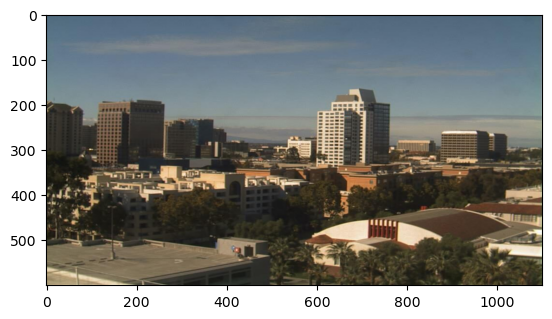

In [14]:
random_img_viz(train_std_img_list)

In [15]:
# Get feature based on average brightness using HSV colorspace
def avg_brightness(image):
    # Convert image to HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate the avg of brightness
    sum_brightness = np.sum(img_hsv[:,:,2]) # take the 3rb value which is the V channel
    area = image.shape[0] * image.shape[1]
    avg = sum_brightness / area

    return avg

In [16]:
# Check on random image
rand_img = np.random.randint(0, len(train_std_img_list))

feature_img = train_std_img_list[rand_img][0]

avg_img = avg_brightness(feature_img)

print(f'Image {rand_img}')
print(f'Avg Brighness: {avg_img:.4f}')
plt.imshow(feature_img)

Image 84
Avg Brighness: 117.4150


In [17]:
def predict_label(img, threshold):
    # Computer average brightness
    avg = avg_brightness(img)
    pred = 0

    # Predict the label based on user defined threshold
    if avg > threshold:
        pred = 1
    
    return pred

In [18]:
# Test the classifier on train data
rand_img = np.random.randint(0, len(train_std_img_list))

pred = predict_label(train_std_img_list[rand_img][0], threshold=120)

# Evaluate
print(f'Image {rand_img}')
print(f'Actual label: {train_std_img_list[rand_img][1]}')
print(f'Predicted label: {pred}')
plt.imshow(train_std_img_list[rand_img][0])

Image 84
Actual label: 1
Predicted label: 0


In [19]:
def evaluate(img_list, threshold):
    miss_labels = []

    for file in img_list:
        # Get the ground truth / correct label
        img = file[0]
        label = file[1]

        # Get prediction
        pred_label = predict_label(img, threshold)

        # Compare ground truth and pred
        if pred_label != label:
            miss_labels.append((img, pred_label, label))
    
    total_img = len(img_list)
    corr_pred = total_img - len(miss_labels)
    accuracy = corr_pred / total_img
    
    return accuracy, miss_labels

In [20]:
# Evaluate on train data
accuracy_train, _ = evaluate(train_std_img_list, threshold=103)

print(f'Accuracy on Train: {accuracy_train:.4f}')


test_img = load_dataset(test_dir)
test_std_img_list = preprocess(test_img)
accuracy_test, _ = evaluate(test_std_img_list, threshold=103)

print(f'Accuracy on Test: {accuracy_test:.4f}')

Accuracy on Train: 0.9125
Accuracy on Test: 0.9250


# Another Way - Membuat Feature Vectors dan Klasifikasi dengan SVM

In [21]:
# Create function to extract feature for every images and stored in tabular data
# Stored in Pandas dataframe
def extract_avg_bright_feature(img_list):
    avg_list = []
    labels = []

    for img in img_list:
        img_avg = avg_brightness(img[0]) # Get the avg brightness from image
        img_label = img[1] # Get the image label

        avg_list.append(img_avg)
        labels.append(img_label)
    
    # Stack data in columcular way
    data = np.column_stack((avg_list, labels))
    # Create a Pandas dataframe
    df = pd.DataFrame(data, columns=['AVG_BRIGHT', 'LABELS'])

    return df

In [22]:
# Extract feature on train data
train_avg_img = extract_avg_bright_feature(train_std_img_list)
print(f'Shape: {train_avg_img.shape}')
train_avg_img.head()

Shape: (240, 2)


AVG_BRIGHT  LABELS
0  137.345858     1.0
1  129.001000     1.0
2  200.020276     1.0
3  165.241074     1.0
4  191.533608     1.0

In [23]:
# Do the same thing on test data
test_avg_img = extract_avg_bright_feature(test_std_img_list)
print(f'Shape: {test_avg_img.shape}')
test_avg_img.head()

Shape: (160, 2)


AVG_BRIGHT  LABELS
0  157.918309     1.0
1  183.717738     1.0
2  132.523694     1.0
3  127.443791     1.0
4  150.264005     1.0

# Langkah 5 alternatif

In [24]:
# import requied library
from sklearn.svm import SVC

# Split data and label
X_train = train_avg_img.iloc[:,0].values.reshape(-1,1)
y_train = train_avg_img.iloc[:,1]
X_test = test_avg_img.iloc[:,0].values.reshape(-1,1)
y_test = test_avg_img.iloc[:,1]

model = SVC()
model.fit(X_train, y_train)

SVC()

In [25]:
from sklearn.metrics import accuracy_score

# Make a prediction on train data
y_train_pred = model.predict(X_train)

# Get the accuracy on train data
acc_train = accuracy_score(y_train, y_train_pred)

# Make a prediction on test data
y_test_pred = model.predict(X_test)

# Get the accuracy on test data
acc_test = accuracy_score(y_test, y_test_pred)

# Print Eval Result
print(f'Accuracy on train: {acc_train}')
print(f'Accuracy on test: {acc_test}')

Accuracy on train: 0.8583333333333333
Accuracy on test: 0.9


In [26]:
# use model from sklearn to predict, use openCV camera
def predict_image(img, model, threshold):
    # Standarized the input
    std_img = standarized_input(img)

    # Extract feature
    avg = avg_brightness(std_img)

    # Predict the label
    pred = model.predict([[avg]])

    return pred[0]

# Load the image
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    pred = predict_image(frame, model, threshold=103)
    label = 'day' if pred == 1 else 'night'

    cv2.putText(frame, label, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    cv2.imshow('Day Night Classifier', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

2024-09-19 20:49:16.129 python[90582:5013273] +[IMKClient subclass]: chose IMKClient_Legacy
2024-09-19 20:49:16.129 python[90582:5013273] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
